# Project part 4 by Vladyslav Bezborodov

### Dataset - Animals-10

### [Github](https://github.com/vladyslavBrothervinn/DL4CV)


## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image
from PIL import Image

from torch.utils.data import DataLoader, Dataset, random_split

import random
import time
from tqdm import tqdm


import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.model_selection import ParameterGrid

import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()

%matplotlib inline

In [2]:
# os.getcwd()

In [3]:
data_dir = "../Datasets/raw-img"

## Dataset

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)


In [5]:
class AnimalDataset(Dataset):
    def __init__(self, data_dir, split="train", transform=None, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
        
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir)) 
        self.images = []
        self.labels = []

        all_data = []  # Store all images before splitting

        for label_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                image_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) 
                               if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
                all_data.extend([(img, label_idx) for img in image_files])  

        random.shuffle(all_data)
        
        # Compute split indices
        total = len(all_data)
        train_end = int(total * train_ratio)
        valid_end = train_end + int(total * valid_ratio)

        # Split dataset
        if split == "train":
            data_subset = all_data[:train_end]
        elif split == "valid":
            data_subset = all_data[train_end:valid_end]
        elif split == "test":
            data_subset = all_data[valid_end:]
        else:
            raise ValueError("split must be 'train', 'valid', or 'test'")

        # Store images and labels
        self.images, self.labels = zip(*data_subset) if data_subset else ([], [])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        # Open image using PIL
        image = Image.open(image_path).convert("RGB")  # Convert to RGB

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [6]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

## Transformations

In [7]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
train_dataset = AnimalDataset(data_dir, split="train", transform=transform_train)
valid_dataset = AnimalDataset(data_dir, split="valid", transform=transform_train)
test_dataset = AnimalDataset(data_dir, split="test", transform=transform_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

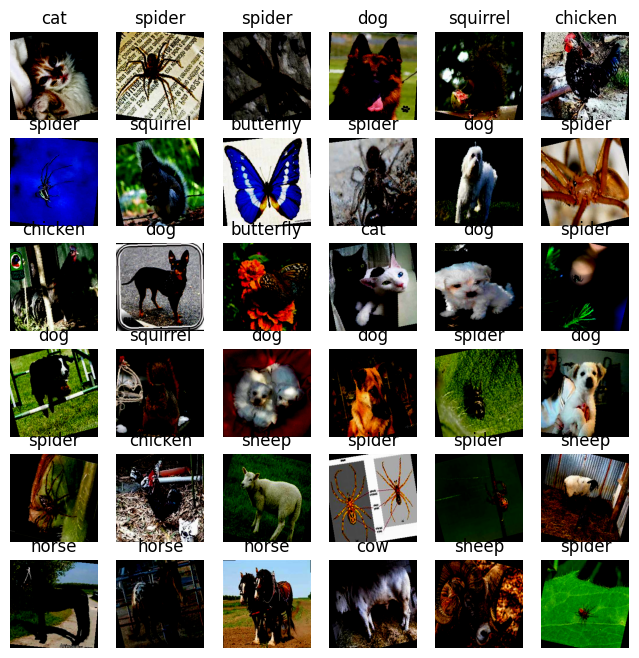

In [9]:
labels_map = {
    0: "butterfly",
    1: "cat",
    2: "chicken",
    3: "cow",
    4: "dog",
    5: "elephant",
    6: "horse",
    7: "sheep",
    8: "spider",
    9: "squirrel",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 6,6
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    img = img.permute(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)
    
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label.item()]) 
    plt.axis("off")
    plt.imshow(img) 

plt.show()


## Fit function

In [25]:
def fit(epochs, model, idx, loss_func, optimizer, train_loader, valid_loader, patience=4, scheduler=None):
    graphic_losses = []
    wait = 0
    valid_loss_min = np.Inf
    # resnet_blocks = [model.layer4, model.layer3, model.layer2, model.layer1]
    resnet_blocks = [model.layer4, model.layer3]

    for epoch in tqdm(range(epochs)):
        # Gradual unfreeze
        if epoch < len(resnet_blocks):
            for param in resnet_blocks[epoch].parameters():
                param.requires_grad = True
        
        model.train()

        # losses = []
        # for X, y  in train_loader:
        #   losses.append(loss(model, loss_func, X, y, optimizer))

        losses, corrects, nums = zip(*[loss(model, loss_func, X, y, optimizer) for X, y in train_loader])
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)
        train_accuracy = sum(corrects) / sum(nums) * 100


        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100

            print(f"\nepoch: {epoch+1:3}, train loss: {train_loss:.5f}, train accuracy: {train_accuracy:.3f}%, valid loss: {valid_loss:.5f}, valid accuracy: {valid_accuracy:.3f}%")

            graphic_losses.append((train_loss, train_accuracy, valid_loss, valid_accuracy))

            if scheduler: scheduler.step(valid_loss)
            
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), f'lab6/models/resnet50_v{idx}.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses

    return graphic_losses

In [26]:
def loss(model, loss_func, X, y, optimizer=None):
    out = model(X)
    loss_ = loss_func(out, y)
    preds = torch.argmax(out, dim=1)
    correct = (preds == y).sum().item()

    if optimizer:
        loss_.backward()
        optimizer.step()
        optimizer.zero_grad()

    return loss_.item(), correct, len(X)


In [27]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X)

In [28]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")
    return test_loss, test_accuracy

In [61]:
def train(model, idx, criterion, optimizer, n_epochs, batch_size, saving_model_path):

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

    train_dataset = AnimalDataset(data_dir, split="train", transform=transform_train)
    valid_dataset = AnimalDataset(data_dir, split="valid", transform=transform_train)
    test_dataset = AnimalDataset(data_dir, split="test", transform=transform_test)

    train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=batch_size, shuffle=True), to_device)
    valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=batch_size, shuffle=False), to_device)
    test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=batch_size, shuffle=False), to_device)
    
    print('\nFitting nn model')
    start_time = time.time()

    losses_arr = fit(n_epochs, model, idx, criterion, optimizer, train_loader, valid_loader, scheduler=scheduler)
    print(f'Fit time: {time.time() - start_time} seconds --> {(time.time() - start_time)/60} minutes')

    check_point = torch.load(f'lab6/models/resnet50_v{idx}.pt', map_location=device)
    model.load_state_dict(check_point)

    test_loss, test_accuracy = evaluate(model, criterion, test_loader)

    if saving_model_path is not None:
        print('Saving model')
        torch.save(model.state_dict(), model_path_v2(saving_model_path))

    training_plots(losses_arr)
    return losses_arr, test_loss, test_accuracy

In [30]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[1] for x in losses_arr], label='train accuracy')
    plt.plot([x[3] for x in losses_arr], label='validation accuracy')
    plt.legend(loc="upper right")
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[2] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

## Parameters grid

### Model for transfer learning - ResNet50

- made a decision to unfreeze only two top layers of the model, as further unfreezing leads to more computations and higher training time

In [59]:
model_path = lambda name: f"lab6/models/animals/{name}.model"
params_grid = {
    "batch_size": [256],
    "lr": [0.004, 0.0025, 0.001, 0.0001, 0.00001],
    "epochs": [10],
    "activation_fn": [nn.GELU()],
    "optimizer" : [torch.optim.Adam, torch.optim.AdamW]
}

In [32]:
def grid_search(params_grid):
    param_grid = ParameterGrid(params_grid)
    df = pd.DataFrame(columns=["batch_size", "lr", "epochs", "activation_fn",
                               "optimizer", "losses_arr", "test_loss", "test_accuracy", "model"])
    
    idx = 0
    for params in param_grid:

        weights = ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, 10)  # 10 класів
        for param in model.fc.parameters():
            param.requires_grad = True
        model.to(device)
        
        
        optimizer = params["optimizer"](filter(lambda p: p.requires_grad, model.parameters()), lr=params["lr"])
        
        criterion = nn.CrossEntropyLoss()
        losses_arr, test_loss, test_accuracy = train(model, idx, criterion, optimizer,
                                                     params["epochs"], params["batch_size"], 'resnet_finetuned_'+str(idx))

        new_row = {
            "batch_size": params["batch_size"],
            "lr": params["lr"],
            "epochs": params["epochs"],
            "activation_fn": params["activation_fn"],
            "optimizer": params["optimizer"].__name__, 
            "losses_arr": losses_arr,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "model": "model_"+str(idx)
        }
        new_df = pd.DataFrame([new_row])
        df = pd.concat([df, new_df], ignore_index=True)
        
        idx += 1

        df.to_csv('lab6/models/models_results.csv', sep=',')
        print("results were saved to csv")
    return df



Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:01<27:09, 181.08s/it]


epoch:   1, train loss: 0.32172, train accuracy: 92.529%, valid loss: 0.10406, valid accuracy: 97.249%
Validation loss decreased (inf --> 0.104056). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:32<26:31, 198.90s/it]


epoch:   2, train loss: 0.10025, train accuracy: 97.468%, valid loss: 0.08756, valid accuracy: 97.822%
Validation loss decreased (0.104056 --> 0.087560). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:04<23:54, 204.95s/it]


epoch:   3, train loss: 0.07824, train accuracy: 97.899%, valid loss: 0.07468, valid accuracy: 97.861%
Validation loss decreased (0.087560 --> 0.074682). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:37<20:49, 208.18s/it]


epoch:   4, train loss: 0.06896, train accuracy: 98.145%, valid loss: 0.06738, valid accuracy: 98.128%
Validation loss decreased (0.074682 --> 0.067384). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:10<17:29, 209.95s/it]


epoch:   5, train loss: 0.06197, train accuracy: 98.292%, valid loss: 0.05909, valid accuracy: 98.491%
Validation loss decreased (0.067384 --> 0.059090). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [20:43<14:03, 210.75s/it]


epoch:   6, train loss: 0.05226, train accuracy: 98.532%, valid loss: 0.05685, valid accuracy: 98.529%
Validation loss decreased (0.059090 --> 0.056852). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:15<10:33, 211.28s/it]


epoch:   7, train loss: 0.04455, train accuracy: 98.772%, valid loss: 0.05264, valid accuracy: 98.491%
Validation loss decreased (0.056852 --> 0.052635). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [27:49<07:04, 212.11s/it]


epoch:   8, train loss: 0.04226, train accuracy: 98.881%, valid loss: 0.05139, valid accuracy: 98.586%
Validation loss decreased (0.052635 --> 0.051385). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:22<03:32, 212.46s/it]


epoch:   9, train loss: 0.04034, train accuracy: 98.816%, valid loss: 0.05128, valid accuracy: 98.548%
Validation loss decreased (0.051385 --> 0.051278). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [34:55<00:00, 209.57s/it]


epoch:  10, train loss: 0.03758, train accuracy: 98.898%, valid loss: 0.04862, valid accuracy: 98.854%
Validation loss decreased (0.051278 --> 0.048623). Saving model...
Fit time: 2095.751041650772 seconds --> 34.92918402751287 minutes


Test loss: 0.05030	Test accruacy: 98.549%
Saving model


results were saved to csv

Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:03<27:34, 183.87s/it]


epoch:   1, train loss: 0.32810, train accuracy: 92.158%, valid loss: 0.11682, valid accuracy: 96.867%
Validation loss decreased (inf --> 0.116817). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:39<27:00, 202.59s/it]


epoch:   2, train loss: 0.10415, train accuracy: 97.255%, valid loss: 0.09411, valid accuracy: 97.650%
Validation loss decreased (0.116817 --> 0.094110). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:15<24:21, 208.73s/it]


epoch:   3, train loss: 0.08335, train accuracy: 97.724%, valid loss: 0.08284, valid accuracy: 97.841%
Validation loss decreased (0.094110 --> 0.082838). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:52<21:11, 211.87s/it]


epoch:   4, train loss: 0.07087, train accuracy: 98.123%, valid loss: 0.07200, valid accuracy: 97.899%
Validation loss decreased (0.082838 --> 0.071996). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:27<17:44, 212.98s/it]


epoch:   5, train loss: 0.06158, train accuracy: 98.330%, valid loss: 0.07197, valid accuracy: 98.300%
Validation loss decreased (0.071996 --> 0.071969). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [21:03<14:15, 213.95s/it]


epoch:   6, train loss: 0.05392, train accuracy: 98.543%, valid loss: 0.06855, valid accuracy: 98.071%
Validation loss decreased (0.071969 --> 0.068549). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:39<10:44, 214.74s/it]


epoch:   7, train loss: 0.05160, train accuracy: 98.516%, valid loss: 0.06450, valid accuracy: 98.453%
Validation loss decreased (0.068549 --> 0.064504). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [28:15<07:10, 215.28s/it]


epoch:   8, train loss: 0.04334, train accuracy: 98.881%, valid loss: 0.06546, valid accuracy: 98.090%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:52<03:35, 215.60s/it]


epoch:   9, train loss: 0.04406, train accuracy: 98.707%, valid loss: 0.05622, valid accuracy: 98.376%
Validation loss decreased (0.064504 --> 0.056219). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [35:29<00:00, 212.90s/it]


epoch:  10, train loss: 0.03836, train accuracy: 98.952%, valid loss: 0.05360, valid accuracy: 98.663%
Validation loss decreased (0.056219 --> 0.053595). Saving model...
Fit time: 2129.025906085968 seconds --> 35.4837651014328 minutes


Test loss: 0.04725	Test accruacy: 98.740%
Saving model


results were saved to csv

Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:02<27:23, 182.59s/it]


epoch:   1, train loss: 0.44223, train accuracy: 90.652%, valid loss: 0.14589, valid accuracy: 96.447%
Validation loss decreased (inf --> 0.145886). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:37<26:52, 201.61s/it]


epoch:   2, train loss: 0.12847, train accuracy: 96.911%, valid loss: 0.10982, valid accuracy: 97.249%
Validation loss decreased (0.145886 --> 0.109820). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:12<24:15, 207.87s/it]


epoch:   3, train loss: 0.09875, train accuracy: 97.512%, valid loss: 0.09023, valid accuracy: 97.880%
Validation loss decreased (0.109820 --> 0.090227). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:48<21:06, 211.04s/it]


epoch:   4, train loss: 0.08263, train accuracy: 97.943%, valid loss: 0.07782, valid accuracy: 97.880%
Validation loss decreased (0.090227 --> 0.077818). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:24<17:43, 212.74s/it]


epoch:   5, train loss: 0.07308, train accuracy: 98.030%, valid loss: 0.07364, valid accuracy: 98.166%
Validation loss decreased (0.077818 --> 0.073642). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [20:59<14:14, 213.54s/it]


epoch:   6, train loss: 0.06733, train accuracy: 98.254%, valid loss: 0.06971, valid accuracy: 98.090%
Validation loss decreased (0.073642 --> 0.069709). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:35<10:42, 214.28s/it]


epoch:   7, train loss: 0.06180, train accuracy: 98.276%, valid loss: 0.06593, valid accuracy: 98.185%
Validation loss decreased (0.069709 --> 0.065930). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [28:10<07:09, 214.69s/it]


epoch:   8, train loss: 0.05709, train accuracy: 98.396%, valid loss: 0.05669, valid accuracy: 98.453%
Validation loss decreased (0.065930 --> 0.056693). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:46<03:34, 214.93s/it]


epoch:   9, train loss: 0.05191, train accuracy: 98.598%, valid loss: 0.05763, valid accuracy: 98.491%


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [35:20<00:00, 212.05s/it]


epoch:  10, train loss: 0.04722, train accuracy: 98.761%, valid loss: 0.05736, valid accuracy: 98.338%
Epoch 00010: reducing learning rate of group 0 to 1.2500e-03.
Fit time: 2120.505101919174 seconds --> 35.34175169865291 minutes


Test loss: 0.05741	Test accruacy: 98.625%
Saving model


results were saved to csv

Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:01<27:13, 181.48s/it]


epoch:   1, train loss: 0.43805, train accuracy: 90.821%, valid loss: 0.13539, valid accuracy: 96.810%
Validation loss decreased (inf --> 0.135395). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:36<26:49, 201.21s/it]


epoch:   2, train loss: 0.12482, train accuracy: 96.982%, valid loss: 0.10612, valid accuracy: 97.192%
Validation loss decreased (0.135395 --> 0.106116). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:12<24:15, 207.93s/it]


epoch:   3, train loss: 0.10000, train accuracy: 97.375%, valid loss: 0.09596, valid accuracy: 97.536%
Validation loss decreased (0.106116 --> 0.095964). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:48<21:05, 210.99s/it]


epoch:   4, train loss: 0.08285, train accuracy: 97.834%, valid loss: 0.08024, valid accuracy: 97.937%
Validation loss decreased (0.095964 --> 0.080237). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:23<17:43, 212.71s/it]


epoch:   5, train loss: 0.07233, train accuracy: 98.145%, valid loss: 0.06951, valid accuracy: 98.319%
Validation loss decreased (0.080237 --> 0.069510). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [20:59<14:14, 213.58s/it]


epoch:   6, train loss: 0.06628, train accuracy: 98.286%, valid loss: 0.06837, valid accuracy: 98.395%
Validation loss decreased (0.069510 --> 0.068366). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:35<10:42, 214.33s/it]


epoch:   7, train loss: 0.05975, train accuracy: 98.379%, valid loss: 0.06091, valid accuracy: 98.434%
Validation loss decreased (0.068366 --> 0.060906). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [28:10<07:09, 214.69s/it]


epoch:   8, train loss: 0.05600, train accuracy: 98.598%, valid loss: 0.05974, valid accuracy: 98.434%
Validation loss decreased (0.060906 --> 0.059743). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:45<03:34, 214.79s/it]


epoch:   9, train loss: 0.05127, train accuracy: 98.619%, valid loss: 0.05717, valid accuracy: 98.472%
Validation loss decreased (0.059743 --> 0.057175). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [35:20<00:00, 212.06s/it]


epoch:  10, train loss: 0.04772, train accuracy: 98.794%, valid loss: 0.05733, valid accuracy: 98.453%
Fit time: 2120.6395761966705 seconds --> 35.34399293661117 minutes


Test loss: 0.05440	Test accruacy: 98.511%
Saving model


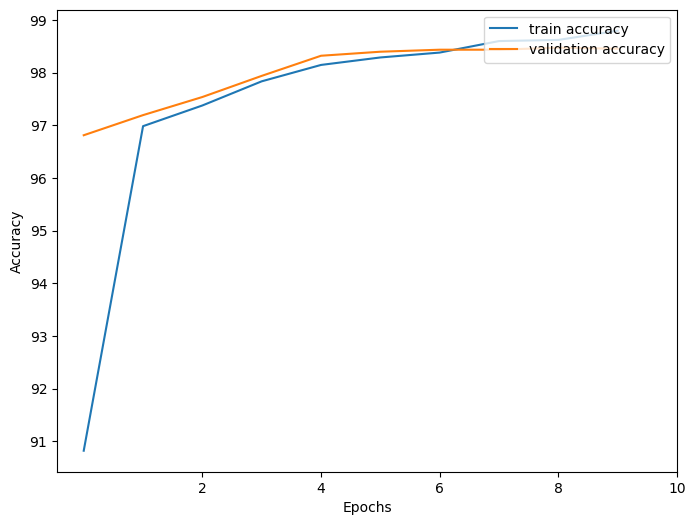

results were saved to csv

Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:02<27:21, 182.38s/it]


epoch:   1, train loss: 0.79069, train accuracy: 85.828%, valid loss: 0.28864, valid accuracy: 95.492%
Validation loss decreased (inf --> 0.288638). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:37<26:52, 201.53s/it]


epoch:   2, train loss: 0.22107, train accuracy: 96.016%, valid loss: 0.18352, valid accuracy: 96.428%
Validation loss decreased (0.288638 --> 0.183523). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:13<24:16, 208.11s/it]


epoch:   3, train loss: 0.15658, train accuracy: 96.851%, valid loss: 0.14534, valid accuracy: 96.562%
Validation loss decreased (0.183523 --> 0.145337). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:49<21:07, 211.21s/it]


epoch:   4, train loss: 0.12741, train accuracy: 97.108%, valid loss: 0.12825, valid accuracy: 96.867%
Validation loss decreased (0.145337 --> 0.128246). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:24<17:44, 212.82s/it]


epoch:   5, train loss: 0.11314, train accuracy: 97.375%, valid loss: 0.11211, valid accuracy: 97.287%
Validation loss decreased (0.128246 --> 0.112109). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [21:01<14:15, 213.95s/it]


epoch:   6, train loss: 0.09767, train accuracy: 97.659%, valid loss: 0.10396, valid accuracy: 97.345%
Validation loss decreased (0.112109 --> 0.103963). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:37<10:44, 214.73s/it]


epoch:   7, train loss: 0.09113, train accuracy: 97.741%, valid loss: 0.09577, valid accuracy: 97.937%
Validation loss decreased (0.103963 --> 0.095770). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [28:12<07:09, 214.99s/it]


epoch:   8, train loss: 0.08565, train accuracy: 97.839%, valid loss: 0.08944, valid accuracy: 97.841%
Validation loss decreased (0.095770 --> 0.089442). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:47<03:34, 214.91s/it]


epoch:   9, train loss: 0.08116, train accuracy: 98.008%, valid loss: 0.08651, valid accuracy: 97.765%
Validation loss decreased (0.089442 --> 0.086511). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [35:23<00:00, 212.34s/it]


epoch:  10, train loss: 0.07345, train accuracy: 98.145%, valid loss: 0.08178, valid accuracy: 97.880%
Validation loss decreased (0.086511 --> 0.081780). Saving model...
Fit time: 2123.379858970642 seconds --> 35.38966431617737 minutes


Test loss: 0.06374	Test accruacy: 98.358%
Saving model


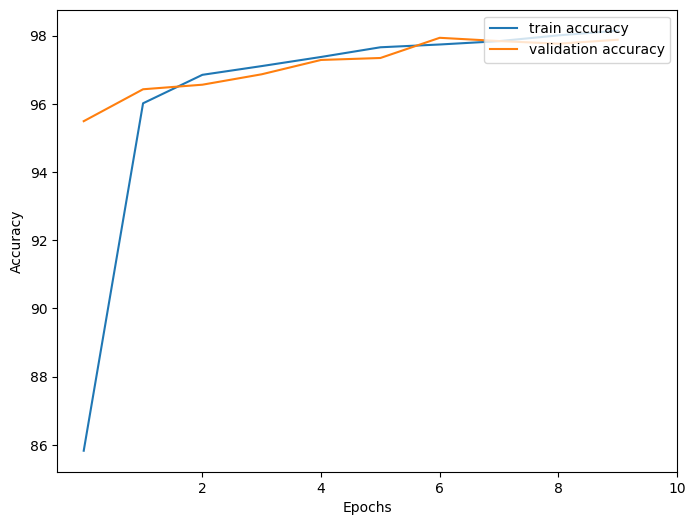

results were saved to csv

Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:03<27:28, 183.15s/it]


epoch:   1, train loss: 0.79667, train accuracy: 85.506%, valid loss: 0.28932, valid accuracy: 95.893%
Validation loss decreased (inf --> 0.289324). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:38<26:58, 202.36s/it]


epoch:   2, train loss: 0.22208, train accuracy: 96.218%, valid loss: 0.17667, valid accuracy: 96.734%
Validation loss decreased (0.289324 --> 0.176668). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:15<24:20, 208.61s/it]


epoch:   3, train loss: 0.16027, train accuracy: 96.655%, valid loss: 0.14166, valid accuracy: 96.963%
Validation loss decreased (0.176668 --> 0.141656). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:51<21:09, 211.59s/it]


epoch:   4, train loss: 0.12812, train accuracy: 97.124%, valid loss: 0.12015, valid accuracy: 97.135%
Validation loss decreased (0.141656 --> 0.120154). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:26<17:44, 212.99s/it]


epoch:   5, train loss: 0.11205, train accuracy: 97.452%, valid loss: 0.10620, valid accuracy: 97.498%
Validation loss decreased (0.120154 --> 0.106201). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [21:02<14:15, 213.93s/it]


epoch:   6, train loss: 0.10133, train accuracy: 97.588%, valid loss: 0.09718, valid accuracy: 97.689%
Validation loss decreased (0.106201 --> 0.097178). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:38<10:43, 214.50s/it]


epoch:   7, train loss: 0.09329, train accuracy: 97.724%, valid loss: 0.09245, valid accuracy: 97.708%
Validation loss decreased (0.097178 --> 0.092446). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [28:14<07:10, 215.01s/it]


epoch:   8, train loss: 0.08502, train accuracy: 97.866%, valid loss: 0.08515, valid accuracy: 97.899%
Validation loss decreased (0.092446 --> 0.085154). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:50<03:35, 215.50s/it]


epoch:   9, train loss: 0.07987, train accuracy: 97.948%, valid loss: 0.08425, valid accuracy: 97.841%
Validation loss decreased (0.085154 --> 0.084246). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [35:27<00:00, 212.71s/it]


epoch:  10, train loss: 0.07462, train accuracy: 98.106%, valid loss: 0.08009, valid accuracy: 98.109%
Validation loss decreased (0.084246 --> 0.080092). Saving model...
Fit time: 2127.128879547119 seconds --> 35.452147992451984 minutes


Test loss: 0.06351	Test accruacy: 98.167%
Saving model


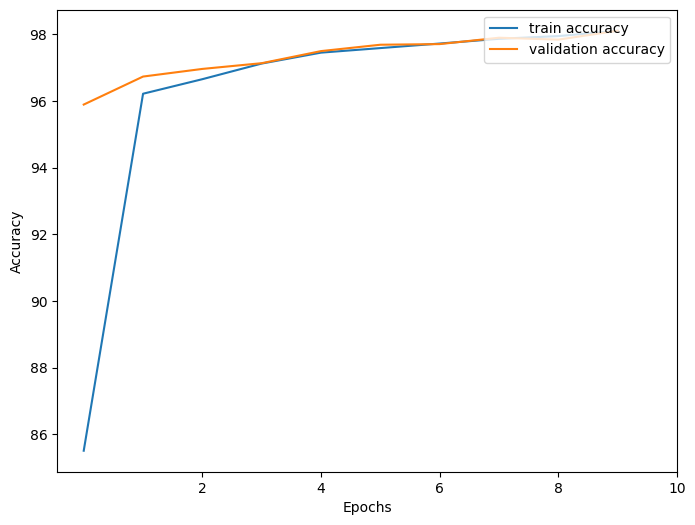

results were saved to csv

Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:02<27:19, 182.20s/it]


epoch:   1, train loss: 1.94151, train accuracy: 51.443%, valid loss: 1.63331, valid accuracy: 70.564%
Validation loss decreased (inf --> 1.633306). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:37<26:53, 201.65s/it]


epoch:   2, train loss: 1.41516, train accuracy: 80.535%, valid loss: 1.21241, valid accuracy: 87.488%
Validation loss decreased (1.633306 --> 1.212407). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:13<24:16, 208.04s/it]


epoch:   3, train loss: 1.06432, train accuracy: 89.703%, valid loss: 0.93725, valid accuracy: 91.920%
Validation loss decreased (1.212407 --> 0.937254). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:49<21:07, 211.23s/it]


epoch:   4, train loss: 0.83046, train accuracy: 92.813%, valid loss: 0.74275, valid accuracy: 93.181%
Validation loss decreased (0.937254 --> 0.742746). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:24<17:44, 212.84s/it]


epoch:   5, train loss: 0.67208, train accuracy: 93.975%, valid loss: 0.61651, valid accuracy: 94.040%
Validation loss decreased (0.742746 --> 0.616506). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [21:00<14:15, 213.92s/it]


epoch:   6, train loss: 0.56090, train accuracy: 94.559%, valid loss: 0.52689, valid accuracy: 94.995%
Validation loss decreased (0.616506 --> 0.526888). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:36<10:43, 214.40s/it]


epoch:   7, train loss: 0.48241, train accuracy: 95.023%, valid loss: 0.45355, valid accuracy: 94.594%
Validation loss decreased (0.526888 --> 0.453551). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [28:12<07:09, 214.83s/it]


epoch:   8, train loss: 0.42186, train accuracy: 95.214%, valid loss: 0.39846, valid accuracy: 95.339%
Validation loss decreased (0.453551 --> 0.398463). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:47<03:35, 215.13s/it]


epoch:   9, train loss: 0.37284, train accuracy: 95.585%, valid loss: 0.35757, valid accuracy: 95.396%
Validation loss decreased (0.398463 --> 0.357573). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [35:23<00:00, 212.38s/it]


epoch:  10, train loss: 0.33834, train accuracy: 95.678%, valid loss: 0.33079, valid accuracy: 95.530%
Validation loss decreased (0.357573 --> 0.330791). Saving model...
Fit time: 2123.7665569782257 seconds --> 35.39610928297043 minutes


Test loss: 0.31412	Test accruacy: 96.105%
Saving model


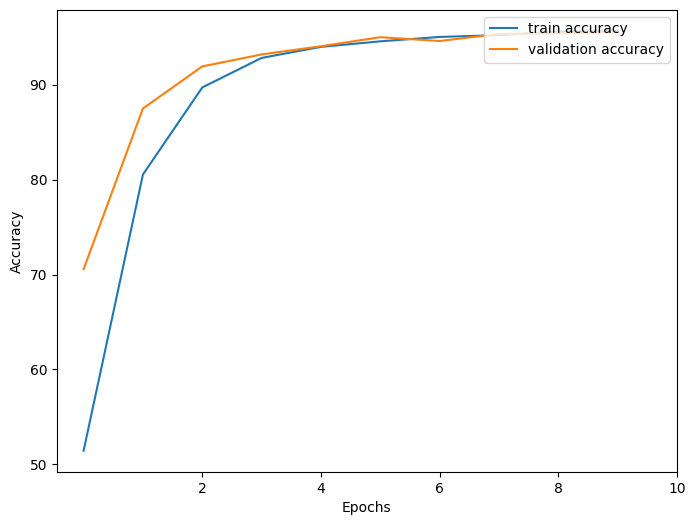

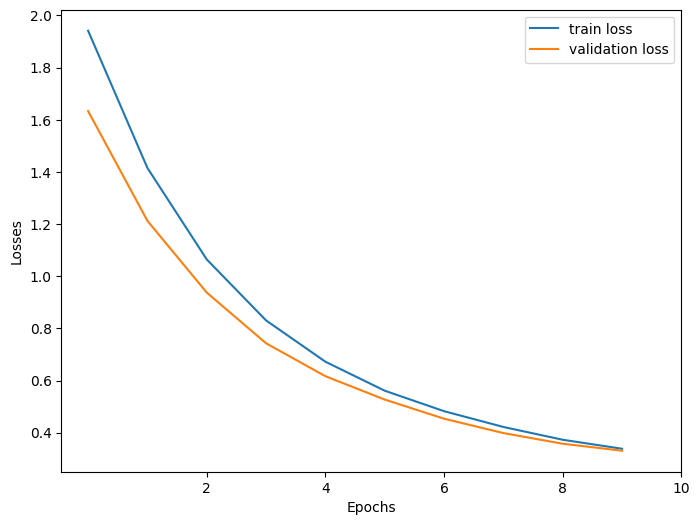

results were saved to csv

Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:03<27:33, 183.77s/it]


epoch:   1, train loss: 1.98016, train accuracy: 48.704%, valid loss: 1.67430, valid accuracy: 67.870%
Validation loss decreased (inf --> 1.674298). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:39<27:00, 202.52s/it]


epoch:   2, train loss: 1.44581, train accuracy: 77.714%, valid loss: 1.24282, valid accuracy: 85.253%
Validation loss decreased (1.674298 --> 1.242818). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:15<24:20, 208.69s/it]


epoch:   3, train loss: 1.08907, train accuracy: 88.840%, valid loss: 0.95920, valid accuracy: 90.659%
Validation loss decreased (1.242818 --> 0.959202). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:50<21:07, 211.33s/it]


epoch:   4, train loss: 0.85214, train accuracy: 92.087%, valid loss: 0.76234, valid accuracy: 93.066%
Validation loss decreased (0.959202 --> 0.762345). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:27<17:46, 213.29s/it]


epoch:   5, train loss: 0.68745, train accuracy: 93.593%, valid loss: 0.63130, valid accuracy: 94.059%
Validation loss decreased (0.762345 --> 0.631304). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [21:03<14:17, 214.29s/it]


epoch:   6, train loss: 0.57359, train accuracy: 94.325%, valid loss: 0.53801, valid accuracy: 94.422%
Validation loss decreased (0.631304 --> 0.538006). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:38<10:43, 214.56s/it]


epoch:   7, train loss: 0.49021, train accuracy: 95.089%, valid loss: 0.46784, valid accuracy: 95.148%
Validation loss decreased (0.538006 --> 0.467836). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [28:15<07:10, 215.13s/it]


epoch:   8, train loss: 0.42913, train accuracy: 95.192%, valid loss: 0.41175, valid accuracy: 95.186%
Validation loss decreased (0.467836 --> 0.411750). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:51<03:35, 215.49s/it]


epoch:   9, train loss: 0.38218, train accuracy: 95.471%, valid loss: 0.36587, valid accuracy: 95.282%
Validation loss decreased (0.411750 --> 0.365873). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [35:27<00:00, 212.77s/it]


epoch:  10, train loss: 0.34339, train accuracy: 95.651%, valid loss: 0.33716, valid accuracy: 95.587%
Validation loss decreased (0.365873 --> 0.337157). Saving model...
Fit time: 2127.6598451137543 seconds --> 35.46099741856257 minutes


Test loss: 0.32964	Test accruacy: 95.380%
Saving model


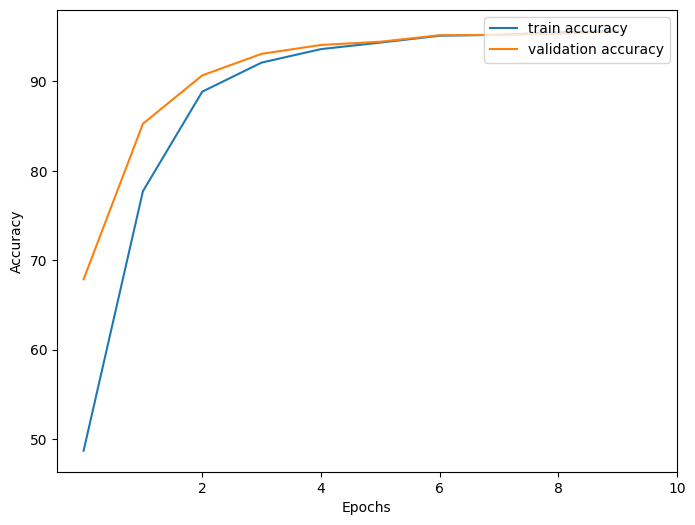

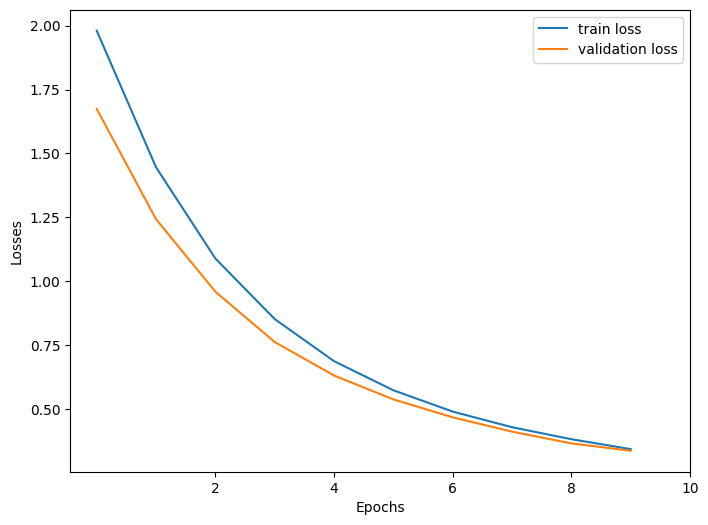

results were saved to csv

Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:02<27:19, 182.18s/it]


epoch:   1, train loss: 2.26458, train accuracy: 20.115%, valid loss: 2.22525, valid accuracy: 26.800%
Validation loss decreased (inf --> 2.225247). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:38<26:56, 202.07s/it]


epoch:   2, train loss: 2.18706, train accuracy: 32.889%, valid loss: 2.15401, valid accuracy: 38.147%
Validation loss decreased (2.225247 --> 2.154012). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:14<24:21, 208.75s/it]


epoch:   3, train loss: 2.11503, train accuracy: 42.876%, valid loss: 2.08322, valid accuracy: 46.189%
Validation loss decreased (2.154012 --> 2.083220). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:50<21:08, 211.44s/it]


epoch:   4, train loss: 2.04715, train accuracy: 49.741%, valid loss: 2.01749, valid accuracy: 52.073%
Validation loss decreased (2.083220 --> 2.017490). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:28<17:49, 213.91s/it]


epoch:   5, train loss: 1.98121, train accuracy: 54.903%, valid loss: 1.94938, valid accuracy: 57.058%
Validation loss decreased (2.017490 --> 1.949380). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [21:04<14:18, 214.59s/it]


epoch:   6, train loss: 1.91829, train accuracy: 58.521%, valid loss: 1.89174, valid accuracy: 59.885%
Validation loss decreased (1.949380 --> 1.891741). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:42<10:47, 215.75s/it]


epoch:   7, train loss: 1.85866, train accuracy: 61.228%, valid loss: 1.83022, valid accuracy: 62.732%
Validation loss decreased (1.891741 --> 1.830216). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [28:19<07:12, 216.17s/it]


epoch:   8, train loss: 1.80031, train accuracy: 63.471%, valid loss: 1.77661, valid accuracy: 65.349%
Validation loss decreased (1.830216 --> 1.776606). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:56<03:36, 216.29s/it]


epoch:   9, train loss: 1.74469, train accuracy: 65.926%, valid loss: 1.72072, valid accuracy: 67.259%
Validation loss decreased (1.776606 --> 1.720718). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [35:33<00:00, 213.36s/it]


epoch:  10, train loss: 1.69126, train accuracy: 68.196%, valid loss: 1.66562, valid accuracy: 69.914%
Validation loss decreased (1.720718 --> 1.665623). Saving model...
Fit time: 2133.613040447235 seconds --> 35.560217340787254 minutes


Test loss: 1.65668	Test accruacy: 69.569%
Saving model


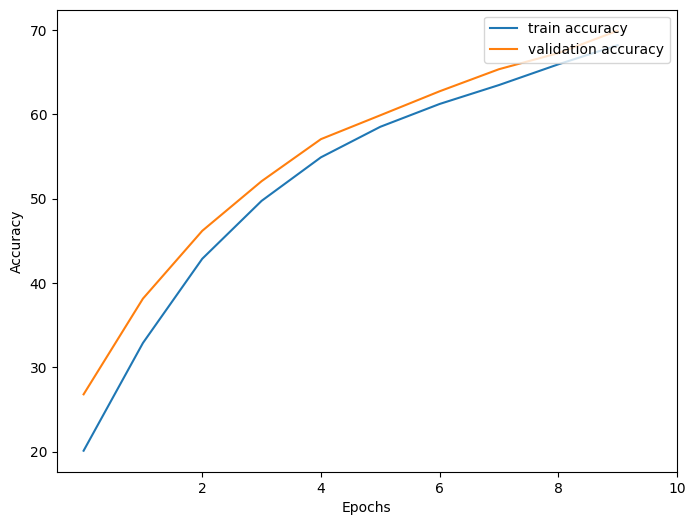

results were saved to csv

Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:02<27:21, 182.43s/it]


epoch:   1, train loss: 2.27384, train accuracy: 15.798%, valid loss: 2.23059, valid accuracy: 20.707%
Validation loss decreased (inf --> 2.230591). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:39<27:01, 202.73s/it]


epoch:   2, train loss: 2.19707, train accuracy: 25.097%, valid loss: 2.15514, valid accuracy: 31.060%
Validation loss decreased (2.230591 --> 2.155143). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:16<24:24, 209.21s/it]


epoch:   3, train loss: 2.12415, train accuracy: 36.049%, valid loss: 2.08593, valid accuracy: 41.490%
Validation loss decreased (2.155143 --> 2.085928). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:52<21:12, 212.00s/it]


epoch:   4, train loss: 2.05410, train accuracy: 45.217%, valid loss: 2.02072, valid accuracy: 49.494%
Validation loss decreased (2.085928 --> 2.020716). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:30<17:51, 214.23s/it]


epoch:   5, train loss: 1.98787, train accuracy: 53.004%, valid loss: 1.95221, valid accuracy: 56.829%
Validation loss decreased (2.020716 --> 1.952212). Saving model...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [21:06<14:19, 214.75s/it]


epoch:   6, train loss: 1.92491, train accuracy: 59.542%, valid loss: 1.89076, valid accuracy: 62.407%
Validation loss decreased (1.952212 --> 1.890764). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:43<10:46, 215.34s/it]


epoch:   7, train loss: 1.86478, train accuracy: 63.809%, valid loss: 1.82928, valid accuracy: 66.323%
Validation loss decreased (1.890764 --> 1.829283). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [28:17<07:10, 215.18s/it]


epoch:   8, train loss: 1.80652, train accuracy: 67.651%, valid loss: 1.77415, valid accuracy: 69.532%
Validation loss decreased (1.829283 --> 1.774146). Saving model...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:53<03:35, 215.41s/it]


epoch:   9, train loss: 1.75063, train accuracy: 70.761%, valid loss: 1.72160, valid accuracy: 72.760%
Validation loss decreased (1.774146 --> 1.721605). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [35:29<00:00, 212.97s/it]


epoch:  10, train loss: 1.69716, train accuracy: 73.135%, valid loss: 1.66508, valid accuracy: 74.709%
Validation loss decreased (1.721605 --> 1.665081). Saving model...
Fit time: 2129.734027147293 seconds --> 35.49556711912155 minutes


Test loss: 1.65498	Test accruacy: 73.769%
Saving model


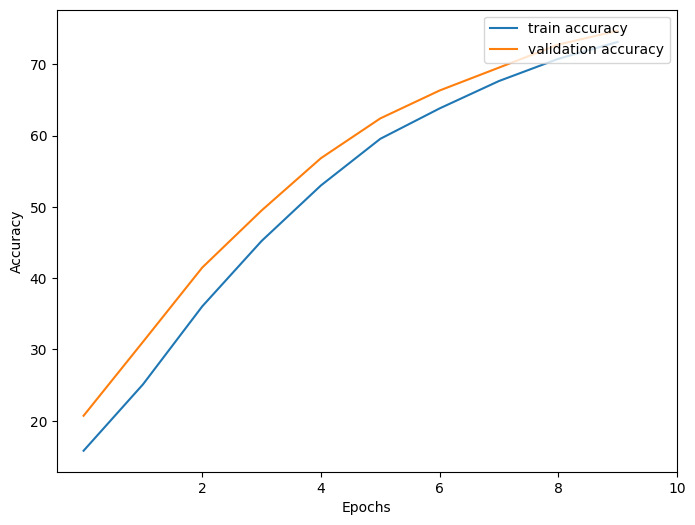

results were saved to csv


In [33]:
df_grid_v1 = grid_search(params_grid)

In [35]:
df_grid_v1

batch_size       lr epochs             activation_fn optimizer  \
0        256  0.00400     10  GELU(approximate='none')      Adam   
1        256  0.00400     10  GELU(approximate='none')     AdamW   
2        256  0.00250     10  GELU(approximate='none')      Adam   
3        256  0.00250     10  GELU(approximate='none')     AdamW   
4        256  0.00100     10  GELU(approximate='none')      Adam   
5        256  0.00100     10  GELU(approximate='none')     AdamW   
6        256  0.00010     10  GELU(approximate='none')      Adam   
7        256  0.00010     10  GELU(approximate='none')     AdamW   
8        256  0.00001     10  GELU(approximate='none')      Adam   
9        256  0.00001     10  GELU(approximate='none')     AdamW   

                                          losses_arr  test_loss  \
0  [(0.3217152800135528, 92.5293315143247, 0.1040...   0.050296   
1  [(0.32810007204544334, 92.15825375170532, 0.11...   0.047245   
2  [(0.442233658541924, 90.65211459754434, 0.1458...   0.057410   
3  [(0.43805012071116395, 90.82128240109141, 0.13...   0.054404   
4  [(0.7906918043426733, 85.8281036834925, 0.2886...   0.063744   
5  [(0.7966689186906099, 85.50613915416099, 0.289...   0.063512   
6  [(1.9415103607971378, 51.44338335607094, 1.633...   0.314124   
7  [(1.9801578422653074, 48.70395634379263, 1.674...   0.329644   
8  [(2.2645785193553887, 20.114597544338338, 2.22...   1.656675   
9  [(2.2738421538614477, 15.798090040927695, 2.23...   1.654978   

   test_accuracy    model  
0      98.549065  model_0  
1      98.739977  model_1  
2      98.625430  model_2  
3      98.510882  model_3  
4      98.358152  model_4  
5      98.167239  model_5  
6      96.105384  model_6  
7      95.379916  model_7  
8      69.568538  model_8  
9      73.768614  model_9

In [38]:
df_grid_v1.iloc[0,-4][-1]

(0.038364400907151534,
 98.95225102319236,
 0.053595470781362446,
 98.66284622731614)

In [37]:
df_grid_v1 = df_grid_v1.sort_values(by='test_accuracy', ascending=False)
df_grid_v1 = df_grid_v1.reset_index(drop=True)

In [40]:
df_grid_v1['train_loss'] = 1
df_grid_v1['train_accuracy'] = 1
df_grid_v1['valid_loss'] = 1
df_grid_v1['valid_accuracy'] = 1

In [42]:
# df_grid_v1

In [43]:
for i in range(df_grid_v1.shape[0]):
    df_grid_v1.iloc[i,9] = df_grid_v1.iloc[i,5][-1][0]
    df_grid_v1.iloc[i,10] = df_grid_v1.iloc[i,5][-1][1]
    df_grid_v1.iloc[i,11] = df_grid_v1.iloc[i,5][-1][2]
    df_grid_v1.iloc[i,12] = df_grid_v1.iloc[i,5][-1][3]

In [44]:
df_grid_v1.head()

batch_size      lr epochs             activation_fn optimizer  \
0        256  0.0040     10  GELU(approximate='none')     AdamW   
1        256  0.0025     10  GELU(approximate='none')      Adam   
2        256  0.0040     10  GELU(approximate='none')      Adam   
3        256  0.0025     10  GELU(approximate='none')     AdamW   
4        256  0.0010     10  GELU(approximate='none')      Adam   

                                          losses_arr  test_loss  \
0  [(0.32810007204544334, 92.15825375170532, 0.11...   0.047245   
1  [(0.442233658541924, 90.65211459754434, 0.1458...   0.057410   
2  [(0.3217152800135528, 92.5293315143247, 0.1040...   0.050296   
3  [(0.43805012071116395, 90.82128240109141, 0.13...   0.054404   
4  [(0.7906918043426733, 85.8281036834925, 0.2886...   0.063744   

   test_accuracy    model  train_loss  train_accuracy  valid_loss  \
0      98.739977  model_1    0.038364       98.952251    0.053595   
1      98.625430  model_2    0.047221       98.761255    0.057357   
2      98.549065  model_0    0.037577       98.897681    0.048623   
3      98.510882  model_3    0.047722       98.793997    0.057331   
4      98.358152  model_4    0.073451       98.144611    0.081780   

   valid_accuracy  
0       98.662846  
1       98.338109  
2       98.853868  
3       98.452722  
4       97.879656

In [45]:
df_grid_v1.to_csv('lab6/models/resnet_finetuned_results.csv', sep=',')

## Top 1 model : 98.73% test accuracy; 98.66% valid accuracy

In [47]:
training_plots(df_grid_v1.iloc[0,5])

In [51]:
def finalizing_plots(models_losses, model_labels):

    plt.figure(figsize=(10, 6))
    for i, losses_arr in enumerate(models_losses):
        val_acc = [x[1] for x in losses_arr]
        plt.plot(val_acc, label=f'{model_labels[i]}')
    plt.ylabel('Train Accuracy (%)')
    plt.xlabel('Epochs')
    plt.xticks([x for x in range(len(models_losses[0])) if x % 2 == 1])
    plt.legend(loc='lower right')
    plt.title("Train Accuracy")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for i, losses_arr in enumerate(models_losses):
        val_loss = [x[0] for x in losses_arr]
        plt.plot(val_loss, label=f'{model_labels[i]}')
    plt.ylabel('Train Loss')
    plt.xlabel('Epochs')
    plt.xticks([x for x in range(len(models_losses[0])) if x % 2 == 1])
    plt.legend(loc='upper right')
    plt.title("Train Loss")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for i, losses_arr in enumerate(models_losses):
        val_acc = [x[3] for x in losses_arr]
        plt.plot(val_acc, label=f'{model_labels[i]}')
    plt.ylabel('Validation Accuracy (%)')
    plt.xlabel('Epochs')
    plt.xticks([x for x in range(len(models_losses[0])) if x % 2 == 1])
    plt.legend(loc='lower right')
    plt.title("Validation Accuracy")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for i, losses_arr in enumerate(models_losses):
        val_loss = [x[2] for x in losses_arr]
        plt.plot(val_loss, label=f'{model_labels[i]}')
    plt.ylabel('Validation Loss')
    plt.xlabel('Epochs')
    plt.xticks([x for x in range(len(models_losses[0])) if x % 2 == 1])
    plt.legend(loc='upper right')
    plt.title("Validation Loss")
    plt.grid(True)
    plt.show()

## Loss and Accuracy for top 5 models

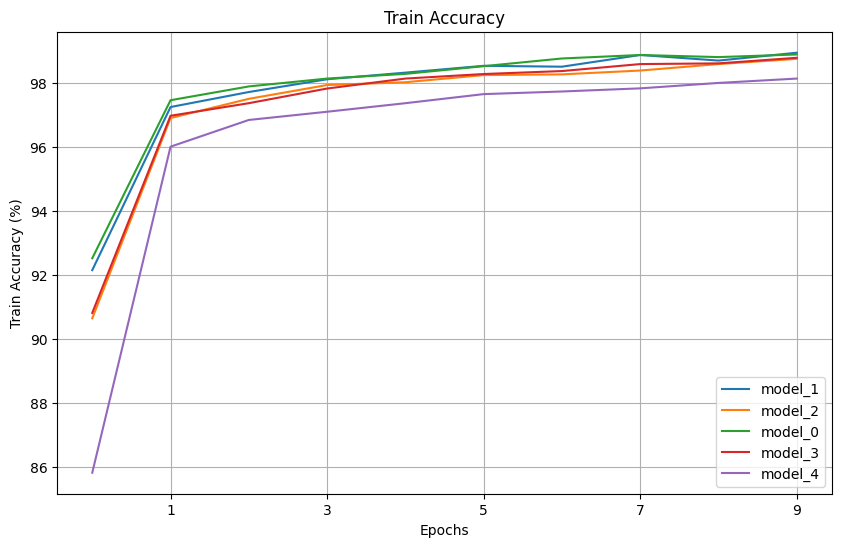

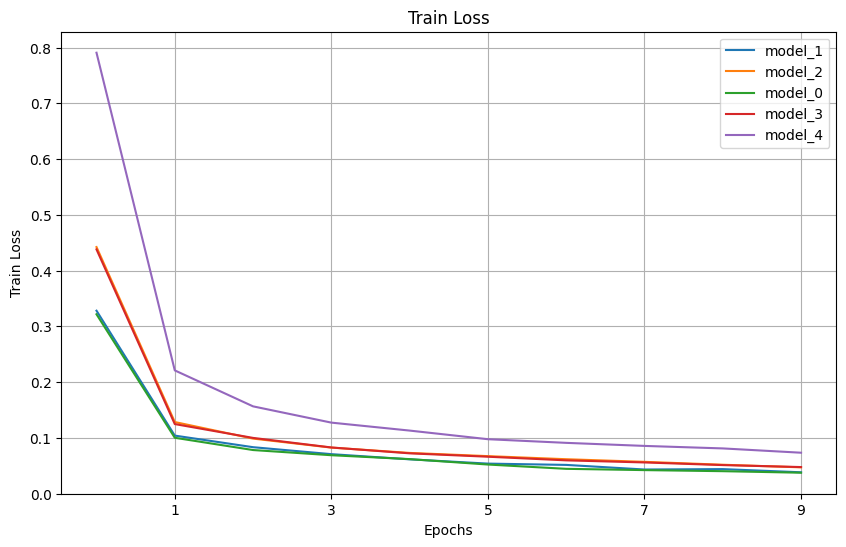

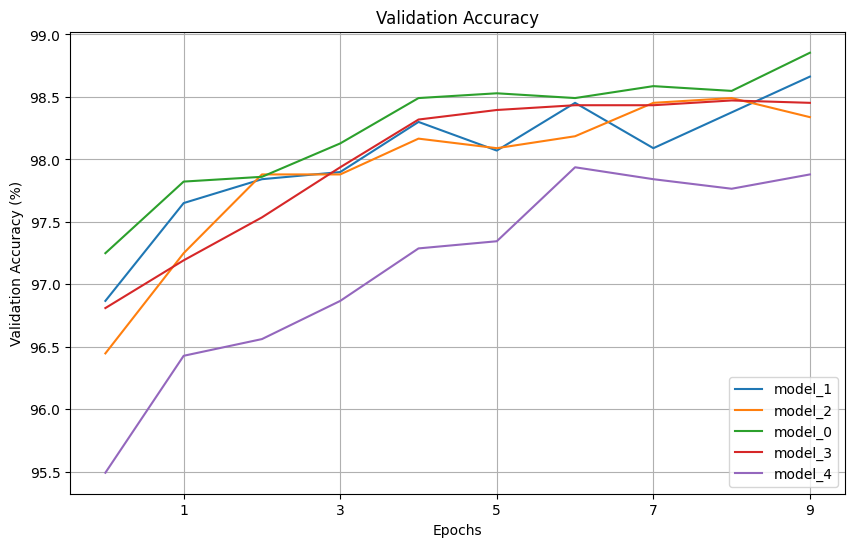

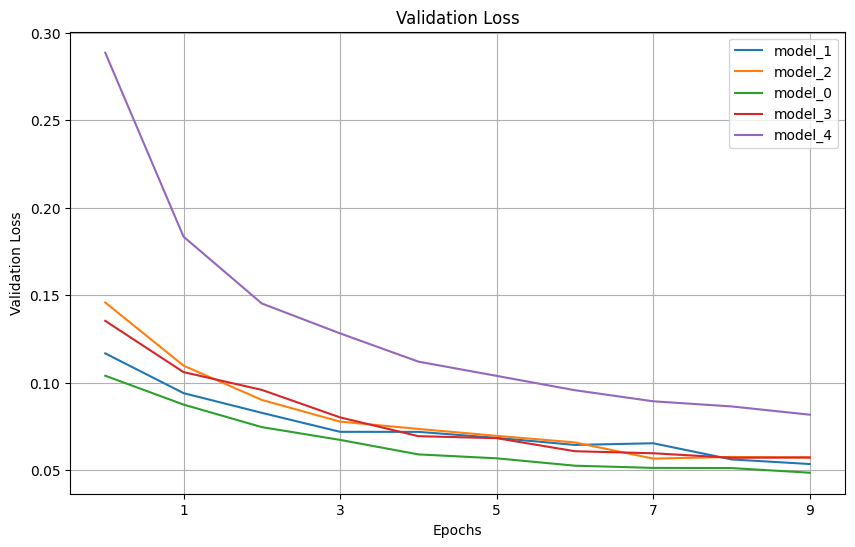

In [52]:
all_models = df_grid_v1['losses_arr'].head().values.tolist()
model_labels = df_grid_v1['model'].head().values.tolist()

finalizing_plots(all_models, model_labels)

## Accuracy vs Hyperparameters

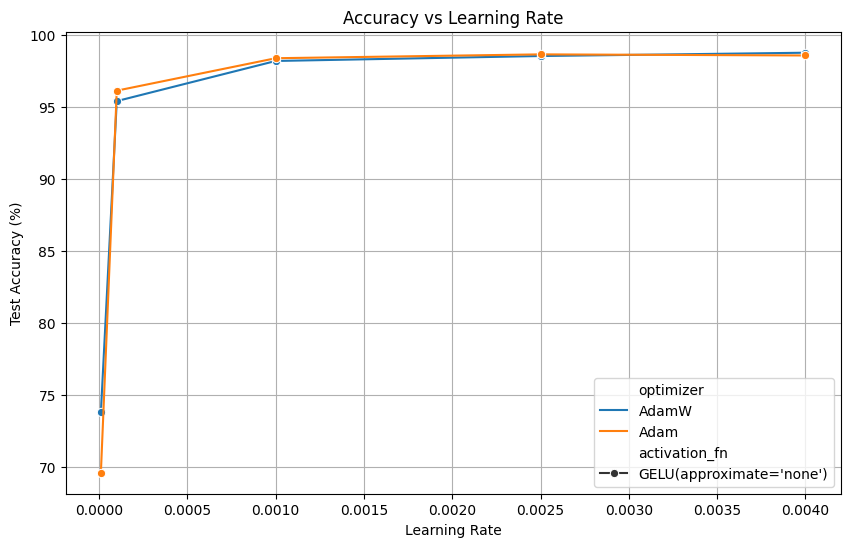

In [55]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_grid_v1, x="lr", y="test_accuracy", hue="optimizer", style="activation_fn", markers=True, dashes=False)
plt.title("Accuracy vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()

## Trainining with unfreezed layers from the start

In [62]:
model_path_v2 = lambda name: f"lab6/models/{name}.model"
params_grid_v2 = {
    "batch_size": [256],
    "lr": [0.004],
    "epochs": [10],
    "activation_fn": [nn.GELU()],
    "optimizer" : [torch.optim.AdamW]
}

weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 10)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [66]:
def grid_search_v2(params_grid, model):
    param_grid = ParameterGrid(params_grid)
    df = pd.DataFrame(columns=["batch_size", "lr", "epochs", "activation_fn",
                               "optimizer", "losses_arr", "test_loss", "test_accuracy", "model"])
    
    idx = 0
    for params in param_grid:
        
        optimizer = params["optimizer"](filter(lambda p: p.requires_grad, model.parameters()), lr=params["lr"])
        
        criterion = nn.CrossEntropyLoss()
        losses_arr, test_loss, test_accuracy = train(model, idx, criterion, optimizer,
                                                     params["epochs"], params["batch_size"], 'resnet_finetuned_'+str(idx))

        new_row = {
            "batch_size": params["batch_size"],
            "lr": params["lr"],
            "epochs": params["epochs"],
            "activation_fn": params["activation_fn"],
            "optimizer": params["optimizer"].__name__, 
            "losses_arr": losses_arr,
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "model": "model_"+str(idx)
        }
        new_df = pd.DataFrame([new_row])
        df = pd.concat([df, new_df], ignore_index=True)
        
        idx += 1

        df.to_csv('lab6/models/models_results.csv', sep=',')
        print("results were saved to csv")
    return df



Fitting nn model


 10%|███████████████████▍                                                                                                                                                                              | 1/10 [03:25<30:53, 205.97s/it]


epoch:   1, train loss: 0.54190, train accuracy: 82.843%, valid loss: 0.38755, valid accuracy: 87.775%
Validation loss decreased (inf --> 0.387549). Saving model...


 20%|██████████████████████████████████████▊                                                                                                                                                           | 2/10 [06:53<27:33, 206.63s/it]


epoch:   2, train loss: 0.22831, train accuracy: 92.835%, valid loss: 0.28041, valid accuracy: 91.213%
Validation loss decreased (0.387549 --> 0.280411). Saving model...


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                       | 3/10 [10:21<24:13, 207.61s/it]


epoch:   3, train loss: 0.19038, train accuracy: 93.872%, valid loss: 0.20170, valid accuracy: 93.352%
Validation loss decreased (0.280411 --> 0.201703). Saving model...


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 4/10 [13:52<20:51, 208.66s/it]


epoch:   4, train loss: 0.14964, train accuracy: 95.132%, valid loss: 0.15853, valid accuracy: 95.033%
Validation loss decreased (0.201703 --> 0.158533). Saving model...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 5/10 [17:23<17:27, 209.57s/it]


epoch:   5, train loss: 0.12446, train accuracy: 96.038%, valid loss: 0.16439, valid accuracy: 94.881%


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 6/10 [20:50<13:55, 208.81s/it]


epoch:   6, train loss: 0.10186, train accuracy: 96.595%, valid loss: 0.14857, valid accuracy: 95.664%
Validation loss decreased (0.158533 --> 0.148566). Saving model...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 7/10 [24:17<10:24, 208.29s/it]


epoch:   7, train loss: 0.09424, train accuracy: 96.971%, valid loss: 0.11976, valid accuracy: 96.294%
Validation loss decreased (0.148566 --> 0.119764). Saving model...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [27:43<06:55, 207.51s/it]


epoch:   8, train loss: 0.08150, train accuracy: 97.381%, valid loss: 0.33276, valid accuracy: 91.691%


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [31:09<03:27, 207.12s/it]


epoch:   9, train loss: 0.07192, train accuracy: 97.621%, valid loss: 0.10335, valid accuracy: 96.925%
Validation loss decreased (0.119764 --> 0.103347). Saving model...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [34:36<00:00, 207.60s/it]


epoch:  10, train loss: 0.06278, train accuracy: 98.019%, valid loss: 0.11921, valid accuracy: 96.428%
Fit time: 2076.004542350769 seconds --> 34.60007570584615 minutes


Test loss: 0.08123	Test accruacy: 97.633%
Saving model


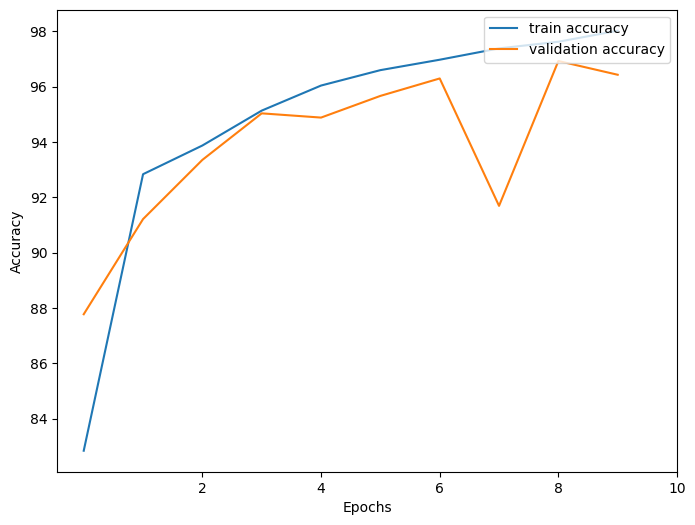

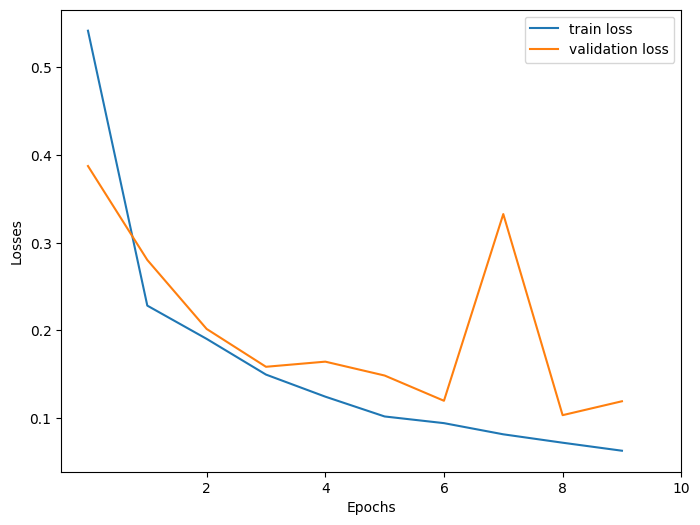

results were saved to csv


In [67]:
df_grid_v2 = grid_search_v2(params_grid_v2, model)

In [72]:
df_grid_v2 = df_grid_v2.sort_values(by='test_accuracy', ascending=False)
df_grid_v2 = df_grid_v2.reset_index(drop=True)

df_grid_v2['train_loss'] = 1
df_grid_v2['train_accuracy'] = 1
df_grid_v2['valid_loss'] = 1
df_grid_v2['valid_accuracy'] = 1

for i in range(df_grid_v2.shape[0]):
    df_grid_v2.iloc[i,9] = df_grid_v2.iloc[i,5][-1][0]
    df_grid_v2.iloc[i,10] = df_grid_v2.iloc[i,5][-1][1]
    df_grid_v2.iloc[i,11] = df_grid_v2.iloc[i,5][-1][2]
    df_grid_v2.iloc[i,12] = df_grid_v2.iloc[i,5][-1][3]
    
df_grid_v2

batch_size     lr epochs             activation_fn optimizer  \
0        256  0.004     10  GELU(approximate='none')     AdamW   

                                          losses_arr  test_loss  \
0  [(0.5419034093545209, 82.8431105047749, 0.3875...   0.081229   

   test_accuracy    model  train_loss  train_accuracy  valid_loss  \
0      97.632684  model_0    0.062783         98.0191    0.119208   

   valid_accuracy  
0       96.427889

In [85]:
df_grid_v1.head(1)  # model_1 , best from gradual unfreezing

batch_size     lr epochs             activation_fn optimizer  \
0        256  0.004     10  GELU(approximate='none')     AdamW   

                                          losses_arr  test_loss  \
0  [(0.32810007204544334, 92.15825375170532, 0.11...   0.047245   

   test_accuracy    model  train_loss  train_accuracy  valid_loss  \
0      98.739977  model_1    0.038364       98.952251    0.053595   

   valid_accuracy  
0       98.662846

## Experiment Gradual vs. Full Unfreezing

- model_1 is our best model from gradual unfreezing training
- model_0 is from full unfreezing 

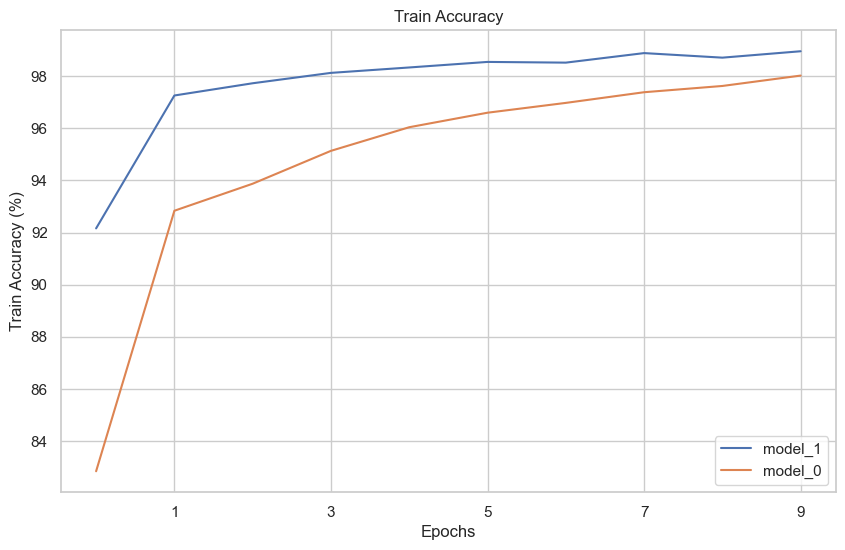

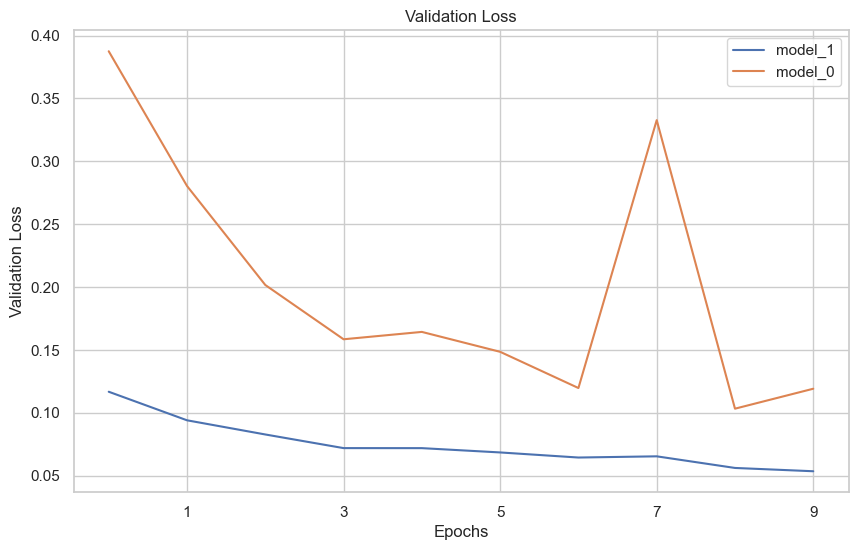

In [86]:
experiment_df = pd.concat([df_grid_v1.head(1), df_grid_v2], ignore_index=True)

all_models = experiment_df['losses_arr'].head().values.tolist()
model_labels = experiment_df['model'].head().values.tolist()

finalizing_plots(all_models, model_labels)

## Best Model Metrics on Test Dataset 

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

sns.set(style="whitegrid")

best_model = models.resnet50(weights=None)  # no pretrained weights
best_model.fc = torch.nn.Linear(model.fc.in_features, 10)  # adapt to your class count
best_model.to(device)

best_model.load_state_dict(torch.load("lab6/models/resnet50_v1.pt", map_location=device))

best_model.eval()
all_preds = []
all_labels = []

test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=256, shuffle=False), to_device)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {acc:.4f}")
print(f"F1 score: {f1:.4f}")

class_names = [
    "butterfly", "cat", "chicken", "cow", "dog",
    "elephant", "horse", "sheep", "spider", "squirrel"
]

# Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, linewidths=.5, square=True, cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix\nAccuracy: {acc:.2%}, F1 Score: {f1:.2%}')
plt.tight_layout()
plt.show()

# Normalized confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=class_names, yticklabels=class_names, square=True, linewidths=0.5)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Normalized Confusion Matrix\nAccuracy: {acc:.2%} | F1 Score: {f1:.2%}")
plt.tight_layout()
plt.show()

Accuracy: 0.9889
F1 score: 0.9871


## Random misclassified images

In [94]:
def show_mis_and_classified_samples(model, loader, class_names, num_images=9):
    model.eval()
    misclassified = []
    classified = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, true in zip(images, preds, labels):
                if pred != true:
                    misclassified.append((img.cpu(), pred.item(), true.item()))
                else:
                    classified.append((img.cpu(), pred.item(), true.item()))

    print(f"Found {len(misclassified)} misclassified and {len(classified)} classified amples.")

    selected_wrongly = random.sample(misclassified, min(num_images, len(misclassified)))

    plt.figure(figsize=(12, 12))
    for i, (img, pred, true) in enumerate(selected_wrongly):
        plt.subplot(3, 3, i+1)
        img = img.permute(1, 2, 0).numpy()  # convert from CHW to HWC
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}", color='red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    selected_correctly = random.sample(classified, min(num_images, len(classified)))

    plt.figure(figsize=(12, 12))
    for i, (img, pred, true) in enumerate(selected_correctly):
        plt.subplot(3, 3, i+1)
        img = img.permute(1, 2, 0).numpy()  # convert from CHW to HWC
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[true]}", color='green')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 29 misclassified and 2590 classified amples.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


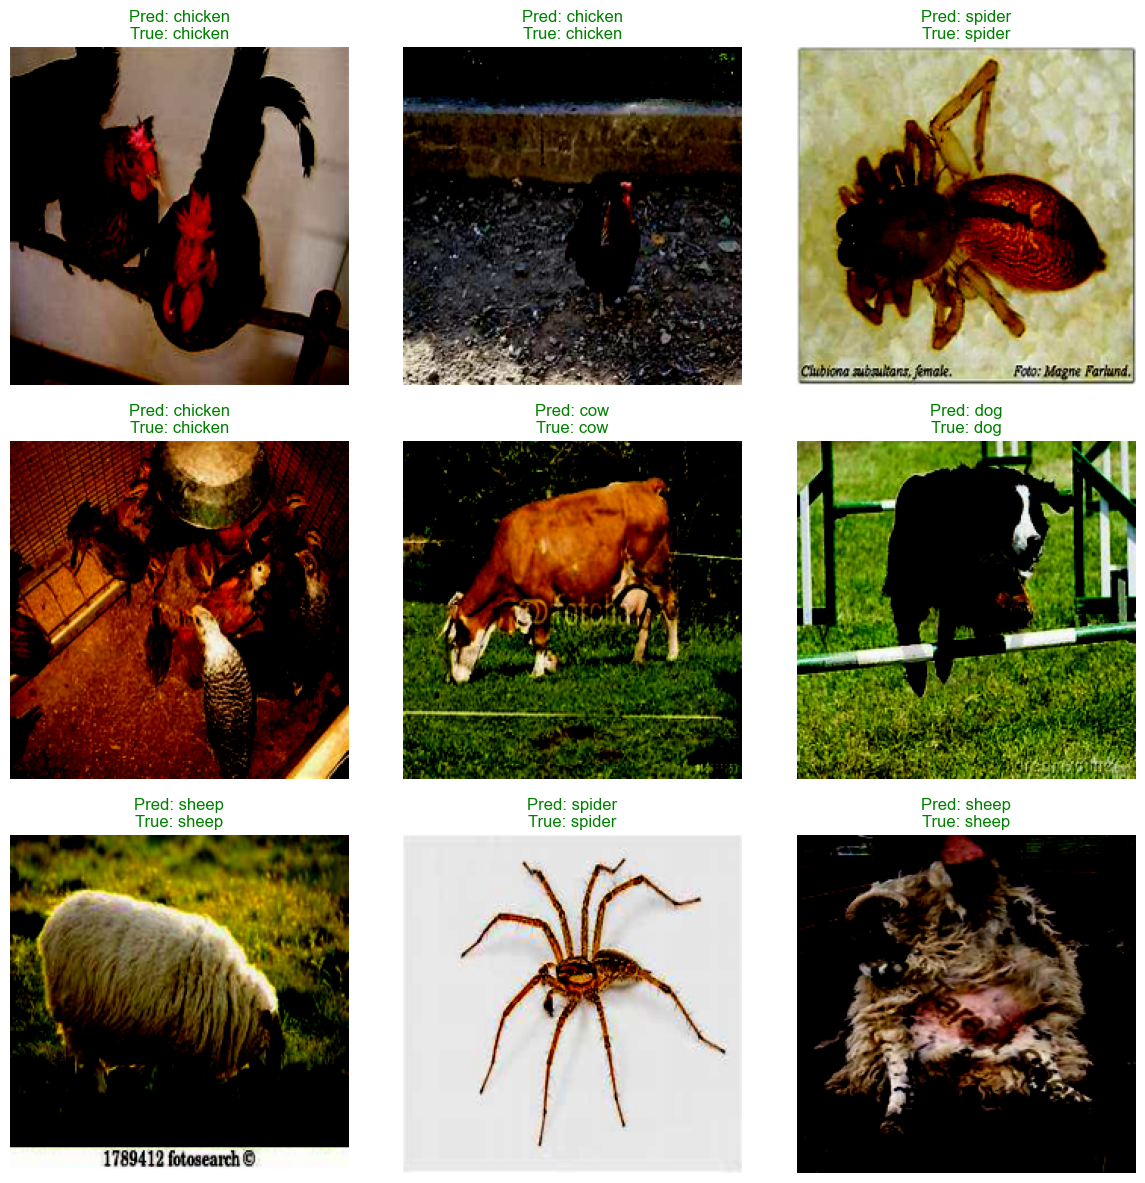

In [97]:
class_names = [
    "butterfly", "cat", "chicken", "cow", "dog",
    "elephant", "horse", "sheep", "spider", "squirrel"
]

show_mis_and_classified_samples(best_model, test_loader, class_names)